<p style="text-align: center;">
    Министерство науки и высшего образования Российской Федерации<br>
    Федеральное государственное автономное образовательное учреждение высшего образования «Национальный исследовательский Нижегородский государственный университет им. Н.И. Лобачевского»<br>
    <br>
    Институт Информационных технологий, математики и механики<br>
    <br><br><br>
    Выпускная квалифиционная работа магистра<br>
    <h1 style="text-align: center;">Исследование влияния различных способов улучшения точности сегментации ЭКГ</h1>
</p>
<br><br><br><br><br>
<p style = "text-align: left; margin-left: 80%;">
    Выполнил:<br>
    студент гр. 381803-1<br>
    <p style = "text-align: left; margin-left: 90%;">
        Мешалкин Н.А.
    </p>
</p>
<br><br><br>
<p style = "text-align: left; margin-left: 80%;">
    Проверил:<br>
    директор ИИТММ<br>
    <p style = "text-align: left; margin-left: 90%;">
        Золотых Ю.Н.
    </p>
</p>
<br><br><br><br>
<p style="text-align: center">
    Нижний Новгород<br>
    2024
</p>

## Введение

**Описание работы:**
Данная работа направлена на изучения влияния на точность сегментационных нейросетей различных способов улучшения точности сегментации. В этом исследовании будет рассмотрено несколько вариантов нейросетей с различными внутренними слоями от самых простых до самых сложных. В качестве нейронной сети, результаты которой следует превзойти, представлена сегментационная нейросеть, подготовленная учеными ННГУ. Данная сеть написана на основе популярной сегментационной сети U-Net. Отличие лишь в том, что данная нейросеть адаптирована под 1D сигнал. Также в качестве базы данных была выбрана собственная база данных ЭКГ, собранная сотрудниками ННГУ. В основе этой базы данных лежат сигналы ЭКГ в 12 отведениях 746 пациентов с частотой дискретизации 500 Гц.

**Цель работы:**
Необходимо проанализировать влияние на точность нейросети различных внутренних слоев. Провести сравнительный анализ, а также сделать заключение о налиучшем варианте нейронной сети, которая будет показывать наилучшую точность.

Данная работа состоит из двух частей: 
1) Разработка собственной нейросети для сегментации сигналов ЭКГ. Разработка будет разобрана шаг за шагом, чтобы можно было отследить влияние на точность различных внутренних слоев, которые будут постепенно добавляться в нейронную сеть.
2) Работа над сегментационной нейросетью от ученых ННГУ. 

## Часть 1. Разработка собственной нейронной сети.

Данный раздел состоит из множества шагов, потому что разработка нейронной сети сложный и трудоемкий процесс. 

### 1.1 Анализ данных.

В качестве данных мы используем сигнал ЭКГ в 12 отведениях с частотой дискретизации 500Гц. В первую очередь необходимо посмотреть на данные.

In [1]:
# Импорт необходимых библиотек
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torch.nn import Module
from typing import Literal
import numpy as np
from torch.utils.data import Dataset
import glob
import torch
import torch.nn.functional as F
from torch import optim
import torch.nn.functional as functional
import matplotlib.pyplot as plt

In [2]:
# Вспомогательные функции, превращающие маску в сегментацию
sample_rate = 500
v_to_del = {1:'p', 2:'qrs', 3:'t'}

def remove_small(signal):
    max_dist = 12
    last_zero = 0
    for i in range(len(signal)):
        if signal[i] == 0:
            if i - last_zero < max_dist:
                signal[last_zero:i] = 0
            last_zero = i

def merge_small(signal):
    max_dist = 12
    lasts = np.full(signal.max() + 1, -(max_dist+1))
    for i in range(len(signal)):
        m = signal[i]
        if i - lasts[m] < max_dist and m > 0:
            signal[lasts[m]:i] = m
        lasts[m] = i

def mask_to_delineation(mask):
    merge_small(mask)
    remove_small(mask)
    delineation = {'p':[], 'qrs':[], 't':[]}
    i = 0
    mask_length = len(mask)
    while i < mask_length:
        v = mask[i]
        if v > 0:
            delineation[v_to_del[v]].append([i, 0])
            while i < mask_length and mask[i] == v:
                delineation[v_to_del[v]][-1][1] = i
                i += 1
            t = delineation[v_to_del[v]][-1]
        i += 1
    return delineation

wave_type_to_color = {
    "p": "yellow",
    "qrs": "red",
    "t": "green"
}

def plot_signal_with_mask(signal, mask):
    plt.figure(figsize=(18, 5))
    plt.title("Сигнал с маской")
    plt.xlabel("Время (сек)")
    plt.ylabel("Амплитуда (мВ)")
    x_axis_values = np.linspace(0, len(signal) / sample_rate, len(signal))
    plt.plot(x_axis_values, signal, linewidth=2, color="black")
    
    delineation = mask_to_delineation(mask)
    for wave_type in ["p", "qrs", "t"]:
        color = wave_type_to_color[wave_type]
        for begin, end in delineation[wave_type]:
            begin /= sample_rate
            end /= sample_rate
            plt.axvspan(begin, end, facecolor=color, alpha=0.5)

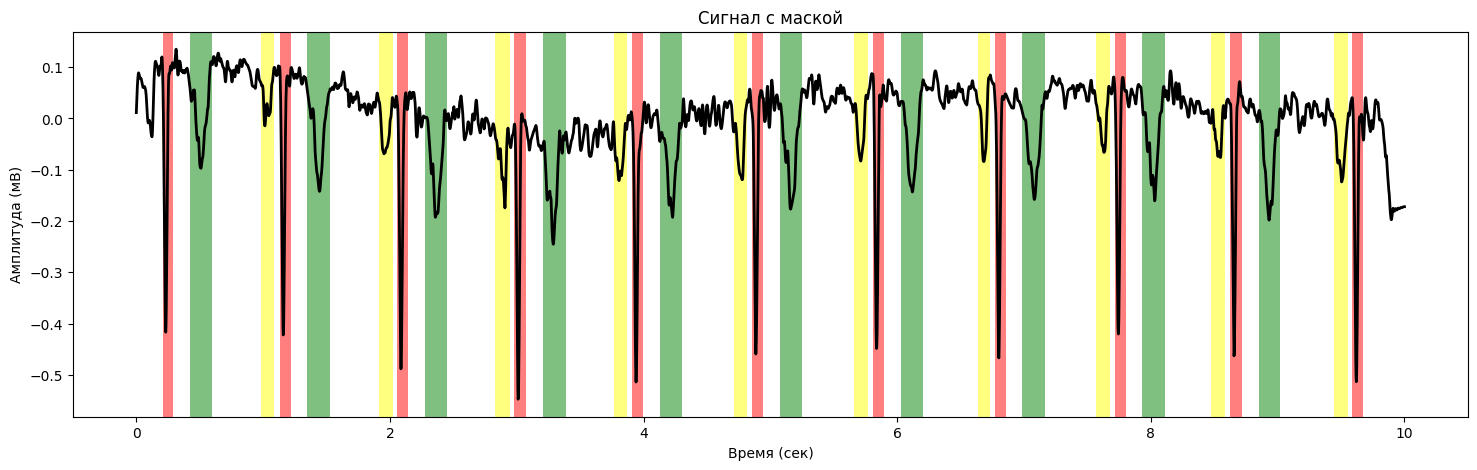

In [3]:
signals = np.load("/home/meshalkin/Diplom/ludb/data/signals/00001_hr_unsupervised.npy")
masks = np.load("/home/meshalkin/Diplom/ludb/data/masks/00001_hr_unsupervised.npy")
index = 3
plot_signal_with_mask(signals[index], masks[index])

Так выглядит сигнал и оригинальная маска. Будем надеяться, что наша нейросеть, покажет такие же результаты!

### 1.2. Разработка метрики для контроля качества модели.

В коде, приведенном ниже производится разработка собственной метрики, основанной на f1score, precision, recall и confusion_matrix. Данная метрика будет отслеживать качество работы модели

In [4]:
class SegmentationMetric:
    def __init__(self,
                 monitor: Literal['p', 'qrs', 't', 'all'] = 'all',
                 orientation_type: Literal['onset', 'offset', 'all'] = 'all',
                 return_type: Literal['precision', 'recall', 'f1', 'confusion_matrix'] = 'confusion_matrix',
                 samples=75):

        assert monitor in ['p', 'qrs', 't', 'all']
        assert orientation_type in ['onset', 'offset', 'all']
        assert return_type in ['precision', 'recall', 'f1', 'confusion_matrix']

        self.samples = samples
        self.monitor = monitor
        self.orientation_type = orientation_type
        self.return_type = return_type
        
        self.metric_to_func = {'precision': self.__precision,
                               'recall': self.__recall,
                               'f1': self.__f1}

    def __call__(self, y_pred, y_true):
        assert y_pred.shape == y_true.shape
        assert len(y_pred.shape) == 2 # Это для батча или для каналов ?
        
        matrix = np.zeros((2, 2), dtype=int)
        monitors = ['p', 'qrs', 't'] if self.monitor == 'all' else [self.monitor]
        orientations = ['onset', 'offset'] if self.orientation_type == 'all' else [self.orientation_type]
        for wave in monitors:
            for orientation in orientations:
                matrix += self.__handle(y_pred, y_true, wave, orientation)
        
        if self.return_type == 'confusion_matrix':
            return matrix

        return self.metric_to_func[self.return_type](matrix[0, 1], matrix[1, 0], matrix[1, 1])

    def __handle(self, y_pred, y_true, wave, orientation) -> tuple[int, int, int]:
        
        index = ['p', 'qrs', 't'].index(wave) + 1
        orientation = 2 * ['offset', 'onset'].index(orientation) - 1
        y_pred[y_true == 4] = 0

        y_true, y_pred = (y_true == index), (y_pred == index)

        wave_true = np.logical_and(np.roll(y_true, orientation) != 1, y_true == 1).astype(int)
        wave_pred = np.logical_and(np.roll(y_pred, orientation) != 1, y_pred == 1).astype(int)

        true_batch, true_indexes = np.where(wave_true == 1)
        
        tp = fn = 0
        
        for batch, x in zip(true_batch, true_indexes):
            wave = wave_pred[batch][x - self.samples // 2: x + self.samples // 2]
            if wave.sum():
                tp += 1
            else:
                fn += 1
            wave[:] = -1
        
        fp = (wave_pred[:, self.samples:-self.samples] == 1).sum()
        return np.array([[0, fp], [fn, tp]])
    
    @staticmethod
    def __precision(fp, fn, tp):
        if fp + tp == 0:
            return 1
        return tp / (tp + fp)
    
    @staticmethod
    def __recall(fp, fn, tp):
        if fn + tp == 0:
            return 1
        return tp / (tp + fn)
    
    @staticmethod
    def __f1(fp, fn, tp):
        precision = SegmentationMetric.__precision(fp, fn, tp)
        recall = SegmentationMetric.__recall(fp, fn, tp)
        if precision + recall == 0:
            return 1
        return 2 * (precision * recall) / (precision + recall)
    
    def __str__(self):
        return f'{self.monitor}_{self.orientation_type}'

### 1.3. Создание датасета для загрузки данных.

Необходимым шагом является правильная загрузка данных, уравнивание длины сигнала, если это необходимо, разделение данных на тренировочную и тестовую выбороки.

In [5]:
batch_size = 2
class SignalDataset(Dataset):
    def __init__(self, data_folder, label_folder, max_length=5000):
        self.data_files = glob.glob(f'{data_folder}/*.npy')
        self.label_files = glob.glob(f'{label_folder}/*.npy')
        self.max_length = max_length

    def __len__(self):
        return len(self.data_files)

    def __getitem__(self, idx):
        data = np.load(self.data_files[idx])
        labels = np.load(self.label_files[idx])

        # Обрезка данных и меток, если длина превышает max_length
        if data.shape[1] > self.max_length:
            data = data[:, :self.max_length]
            labels = labels[:, :self.max_length]

        return torch.from_numpy(data).float(), torch.from_numpy(labels).long()

# Использование DataLoader
data_folder = '/home/meshalkin/Diplom/ludb/data/signals'
label_folder = '/home/meshalkin/Diplom/ludb/data/masks'
dataset = SignalDataset(data_folder, label_folder)

# Например, 20% для валидации
val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size

# Разделите датасет на тренировочный и валидационный
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Создайте DataLoader для обоих датасетов
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # shuffle обычно не нужен для валидации

for i, (signal, label) in enumerate(train_loader):
    print(f"Размеры сигналов и масок с батчом = {batch_size}:")
    print(f"Размер сигнала = {label.shape}")
    print(f"Размер маски = {signal.shape}")
    break

Размеры сигналов и масок с батчом = 2:
Размер сигнала = torch.Size([2, 12, 5000])
Размер маски = torch.Size([2, 12, 5000])


### 1.4. Разработка собственной неросети.

#### 1.4.1 Разработка версии №1. Простейшая full-convolutional сеть.

Начнем с простой нейронной сети с тремя сверточноми слоями внутри. Так как маска распространяется вдоль всех каналов, мы можем объединить их и выдавать результат в виде распределения вероятностей по нашим классам. Точнее будет сказать, что все таки выход будет иметь ненормализированные числа, они нормализуются в процессе обучения.  
То есть, наши данные имеют размер [2,12,5000], где 2 - размер батча, 12 - количество каналов, 5000 - длина сигнала, то выход нейронной сети будет иметь размер [2,4,5000], где 2 - размер батча, 12 - количество классов, 5000 - длина сигнала.

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class SegmentationNetwork(nn.Module):
    def __init__(self, num_channels, num_classes):
        super(SegmentationNetwork, self).__init__()
        self.conv1 = nn.Conv1d(num_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(64, num_classes, kernel_size=3, padding=1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.conv3(x)
        return x

# Пример использования
batch_size = 2
num_channels = 12
length = 5000
num_classes = 4

# Создание модели
model = SegmentationNetwork(num_channels, num_classes).to(device)

# Создание случайных входных данных
inputs = torch.randn(batch_size, num_channels, length)

# Проход через сеть
outputs = model(inputs.to(device))
print(f"Размер входа: {inputs.shape}")
print(f"Размер выхода: {outputs.shape}")  # Распечатает: torch.Size([2, 4, 5000])

Размер входа: torch.Size([2, 12, 5000])
Размер выхода: torch.Size([2, 4, 5000])


Напишем обучающую функцию для данной сети:

In [7]:

def train(model, train_loader, num_epochs=20, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, targets in train_loader:
            targets = targets[:, 0, :].to(device)
            optimizer.zero_grad()
            outputs = model(inputs.to(device))
            loss = criterion(outputs.to(device), targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')

# Пример использования
batch_size = 2
num_channels = 12
length = 5000
num_classes = 4

# Создание модели
model = SegmentationNetwork(num_channels, num_classes)

# Тренировка модели
train(model, train_loader)

Epoch 1/20, Loss: 0.9107116305982912
Epoch 2/20, Loss: 0.8310911239354641
Epoch 3/20, Loss: 0.810581589093456
Epoch 4/20, Loss: 0.7957175445634049
Epoch 5/20, Loss: 0.7766511578645025
Epoch 6/20, Loss: 0.758515783331611
Epoch 7/20, Loss: 0.743146370273906
Epoch 8/20, Loss: 0.7289919098476311
Epoch 9/20, Loss: 0.7179090499684408
Epoch 10/20, Loss: 0.7074661811257338
Epoch 11/20, Loss: 0.6982653497101424
Epoch 12/20, Loss: 0.6892857104539871
Epoch 13/20, Loss: 0.6840200850909407
Epoch 14/20, Loss: 0.6729757837080336
Epoch 15/20, Loss: 0.6651047398517658
Epoch 16/20, Loss: 0.6566105393039716
Epoch 17/20, Loss: 0.6494584144516424
Epoch 18/20, Loss: 0.6419491538560236
Epoch 19/20, Loss: 0.6393212319000975
Epoch 20/20, Loss: 0.6341367575835872


In [8]:
def validate_model_with_metrics(model, validation_loader, metric, device):
    model.to(device)
    model.eval()
    all_metrics = []

    for inputs, labels in validation_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
            
        # Переводим outputs в формат [batch_size, length, num_channels], где num_channels - это наши классы
        _, outputs = torch.max(F.softmax(outputs, dim=1), dim=1)  # получаем наиболее вероятные классы
        if(outputs.shape[0] > 1):
            outputs = torch.cat([outputs[0], outputs[1]], dim=0).cpu() 
        else:
            outputs = outputs[0]
        
        outputs = outputs.unsqueeze(0) 
        outputs = outputs.expand(12, *outputs.shape[1:]).cpu() # считаем по батчу и объединяем, дублируем на 12 -> (12,10000)
        if(labels.shape[0] > 1):
            labels = torch.cat([labels[0],labels[1]], dim=1).cpu() # считаем по батчу и объединяем -> (12,10000)
        else:
            labels = labels[0]
        all_metrics.append(metric(outputs.numpy(), labels.numpy()))
    
    # Средний расчет всех метрик по всем батчам
    if metric.return_type == 'confusion_matrix':
        final_metrics = np.sum(all_metrics, axis=0)
    else:
        final_metrics = np.mean(all_metrics, axis=0)

    return final_metrics

# Пример использования:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
monitor= ['p', 't', 'qrs']
orintation_type = ['onset', 'offset']
print("Current f1 score:")
for m in monitor:
    for o in orintation_type:   
        metric = SegmentationMetric(monitor=m, orientation_type=o, return_type='f1', samples=75)
        validation_metrics = validate_model_with_metrics(model, val_loader, metric, device)
        print(f"{m}_{o}: {round(validation_metrics, 2)}%")

Current f1 score:
p_onset: 0.38%
p_offset: 0.43%
t_onset: 0.46%
t_offset: 0.51%
qrs_onset: 0.82%
qrs_offset: 0.85%


#### 1.4.2 Разработка версии №2. Усложненная full-convolutional сеть с добавлением дополнительных сверточных слоев и слоев пулинга.

В данном разделе интересно было бы проверить предыдущую нейронную сеть с добавлением дополнительных сверточных слоев лои пулинга для увеличения ее способности к извлечению признаков и повышения точности сегментации.

In [11]:
class SegmentationNetworkWithPooling(nn.Module):
    def __init__(self, num_channels, num_classes):
        super(SegmentationNetworkWithPooling, self).__init__()
        self.conv1 = nn.Conv1d(num_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(128, 128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv1d(128, num_classes, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.pool(x)  # Добавляем пулинг со stride=1 и kernel_size=3
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = self.conv5(x)
        return x

# Пример использования
batch_size = 2
num_channels = 12
length = 5000
num_classes = 4

# Создание модели
model = SegmentationNetwork(num_channels, num_classes).to(device)

# Создание случайных входных данных
inputs = torch.randn(batch_size, num_channels, length)

# Проход через сеть
outputs = model(inputs.to(device))

print(f"Размер входа: {inputs.shape}")
print(f"Размер выхода: {outputs.shape}")  # Распечатает: torch.Size([2, 4, 5000])

Размер входа: torch.Size([2, 12, 5000])
Размер выхода: torch.Size([2, 4, 5000])


Теперь обучим данную сеть:

In [12]:
batch_size = 2
num_channels = 12
length = 5000
num_classes = 4

# Создание модели
model = SegmentationNetworkWithPooling(num_channels, num_classes).to(device)

# Тренировка модели
train(model, train_loader)

Epoch 1/20, Loss: 0.8732695236995622
Epoch 2/20, Loss: 0.7724130362659306
Epoch 3/20, Loss: 0.7358157496367183
Epoch 4/20, Loss: 0.7136388083363508
Epoch 5/20, Loss: 0.6984711809978856
Epoch 6/20, Loss: 0.6791554085620037
Epoch 7/20, Loss: 0.6684322147206827
Epoch 8/20, Loss: 0.6475532745773142
Epoch 9/20, Loss: 0.6362113259829484
Epoch 10/20, Loss: 0.6229480428548603
Epoch 11/20, Loss: 0.6239411302588203
Epoch 12/20, Loss: 0.610577665656418
Epoch 13/20, Loss: 0.6070154219285234
Epoch 14/20, Loss: 0.5999381524788869
Epoch 15/20, Loss: 0.591483116730467
Epoch 16/20, Loss: 0.5896994816985998
Epoch 17/20, Loss: 0.58695823708912
Epoch 18/20, Loss: 0.5838740701218704
Epoch 19/20, Loss: 0.5759387813605271
Epoch 20/20, Loss: 0.5732320650637924


In [13]:
# Пример использования:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
monitor= ['p', 't', 'qrs']
orintation_type = ['onset', 'offset']
print("Current f1 score:")
for m in monitor:
    for o in orintation_type:   
        metric = SegmentationMetric(monitor=m, orientation_type=o, return_type='f1', samples=75)
        validation_metrics = validate_model_with_metrics(model, val_loader, metric, device)
        print(f"{m}_{o}: {round(validation_metrics, 2)}%")

Current f1 score:
p_onset: 0.42%
p_offset: 0.5%
t_onset: 0.5%
t_offset: 0.56%
qrs_onset: 0.88%
qrs_offset: 0.9%


Можно заметить как увеличились значения наших метрик. Теперь p волна определяется правильно примерно в ~80% случаев, t волна определяется правильно примерно в ~60% случаев, а qrs сегмент остался на уровне ~55%.

#### 1.4.3 Разработка версии №3. Более глубокая усложненная full-convolutional сеть с добавлением дополнительных сверточных слоев и слоев пулинга.

Давайте добавим еще один блок свертки-пулинга для увеличения глубины и сложности модели. Также мы можем увеличить количество фильтров в каждом сверточном слое для более глубокого извлечения признаков. Вот обновленная версия модели:

In [14]:
import torch
import torch.nn as nn

class HardSegmentationNetworkWithPooling(nn.Module):
    def __init__(self, num_channels, num_classes):
        super(HardSegmentationNetworkWithPooling, self).__init__()
        self.conv1 = nn.Conv1d(num_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(256, 512, kernel_size=3, padding=1)
        self.conv5 = nn.Conv1d(512, 512, kernel_size=3, padding=1)
        self.conv6 = nn.Conv1d(512, 512, kernel_size=3, padding=1)
        self.conv7 = nn.Conv1d(512, 512, kernel_size=3, padding=1)
        self.conv8 = nn.Conv1d(512, num_classes, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.relu(self.conv3(x))
        x = self.pool(x)
        x = torch.relu(self.conv4(x))
        x = self.pool(x)
        x = torch.relu(self.conv5(x))
        x = self.pool(x)
        x = torch.relu(self.conv6(x))
        x = self.pool(x)
        x = torch.relu(self.conv7(x))
        x = self.pool(x)
        x = self.conv8(x)
        return x

# Пример использования
batch_size = 2
num_channels = 12
length = 5000
num_classes = 4

# Создание модели
model = SegmentationNetwork(num_channels, num_classes)

# Создание случайных входных данных
inputs = torch.randn(batch_size, num_channels, length)

# Проход через сеть
outputs = model(inputs)

print(outputs.shape)  # Распечатает: torch.Size([2, 4, 5000])


torch.Size([2, 4, 5000])


Натренируем модель:

In [15]:
batch_size = 2
num_channels = 12
length = 5000
num_classes = 4

# Создание модели
model = HardSegmentationNetworkWithPooling(num_channels, num_classes).to(device)

# Тренировка модели
train(model, train_loader)

Epoch 1/20, Loss: 0.8525674770791809
Epoch 2/20, Loss: 0.7283802487246402
Epoch 3/20, Loss: 0.6798245737498457
Epoch 4/20, Loss: 0.6460889961038317
Epoch 5/20, Loss: 0.6244799911782339
Epoch 6/20, Loss: 0.6081230048235361
Epoch 7/20, Loss: 0.5868251238550458
Epoch 8/20, Loss: 0.567217147679298
Epoch 9/20, Loss: 0.5652847698369583
Epoch 10/20, Loss: 0.5492625278118369
Epoch 11/20, Loss: 0.5452114213016126
Epoch 12/20, Loss: 0.5414040609226598
Epoch 13/20, Loss: 0.5317328899324715
Epoch 14/20, Loss: 0.5262701879074048
Epoch 15/20, Loss: 0.5280979278606254
Epoch 16/20, Loss: 0.5152999461180978
Epoch 17/20, Loss: 0.5135620918076533
Epoch 18/20, Loss: 0.509175465285004
Epoch 19/20, Loss: 0.5025882630959734
Epoch 20/20, Loss: 0.4986351662158192


In [16]:
# Пример использования:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
monitor= ['p', 't', 'qrs']
orintation_type = ['onset', 'offset']
print("Current f1 score:")
for m in monitor:
    for o in orintation_type:   
        metric = SegmentationMetric(monitor=m, orientation_type=o, return_type='f1', samples=75)
        validation_metrics = validate_model_with_metrics(model, val_loader, metric, device)
        print(f"{m}_{o}: {round(validation_metrics, 2)}%")

Current f1 score:
p_onset: 0.49%
p_offset: 0.51%
t_onset: 0.61%
t_offset: 0.61%
qrs_onset: 0.9%
qrs_offset: 0.93%


В данном случае мы видим, что метрика показывает результаты хуже, после усложнения модели дополнительными слоями, потому что увеличение сложности модели не всегда приводит к улучшению ее производительности. Наоборот, в некоторых случаях это может привести к переобучению или затуханию градиентов, особенно если модель становится слишком глубокой или сложной для данной задачи.

#### 1.4.4 Разработка версии №4. UNet-подобная сеть.

Так как элементарное углубление модели для данной задачи с имеющимся количеством данных не приносит ожидаемых результатов, мы можем привести модель к уже имеющимся архитектурам, которые зарекомендовали себя в задаче сегментаци данных, поэтому ниже произведено приведение нашей модели к Unet-подобной архитектуре, добавив соединения между сверточными слоями и их транспонированными аналогами.

In [17]:
import torch
import torch.nn as nn

class SimpleUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SimpleUNet, self).__init__()

        # Энкодер
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )

        # Декодер
        self.decoder = nn.Sequential(
            nn.Conv1d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='linear', align_corners=True)
        )

    def forward(self, x):
        # Прямой проход через энкодер
        x1 = self.encoder(x)
        
        # Прямой проход через декодер
        output = self.decoder(x1)
        return output

# Пример использования
batch_size = 2
num_channels = 12
length = 5000
num_classes = 4

# Создание модели
model = SimpleUNet(num_channels, num_classes)

# Создание случайных входных данных
inputs = torch.randn(batch_size, num_channels, length)

# Проход через сеть
outputs = model(inputs)

print(outputs.shape)  # Распечатает: torch.Size([2, 4, 5000])


torch.Size([2, 4, 5000])


В данном случае, чтобы исследовать поведение UNet-подобной архитектуры мы начнем с простой версии Unet с одним энкодером и одним декодером. Она включает в себя сверточные слои для энкодера и декодера, а также операцию апсэмплинга для увеличения размера выходного изображения.

Натренируем модель:

In [18]:
batch_size = 2
num_channels = 12
length = 5000
num_classes = 4

# Создание модели
model = SimpleUNet(num_channels, num_classes).to(device)

# Тренировка модели
train(model, train_loader, 10)

Epoch 1/10, Loss: 1.300088524044334
Epoch 2/10, Loss: 1.2709616337503706
Epoch 3/10, Loss: 1.0858693807930142
Epoch 4/10, Loss: 0.7836202448838717
Epoch 5/10, Loss: 0.7666925230583588
Epoch 6/10, Loss: 0.7525445749233295
Epoch 7/10, Loss: 0.738971393700544
Epoch 8/10, Loss: 0.7270432562603579
Epoch 9/10, Loss: 0.7169951970701094
Epoch 10/10, Loss: 0.7065320601323982


In [19]:
# Пример использования:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
monitor= ['p', 't', 'qrs']
orintation_type = ['onset', 'offset']
print("Current f1 score:")
for m in monitor:
    for o in orintation_type:   
        metric = SegmentationMetric(monitor=m, orientation_type=o, return_type='f1', samples=75)
        validation_metrics = validate_model_with_metrics(model, val_loader, metric, device)
        print(f"{m}_{o}: {round(validation_metrics, 2)}%")

Current f1 score:
p_onset: 0.06%
p_offset: 0.06%
t_onset: 0.59%
t_offset: 0.61%
qrs_onset: 0.86%
qrs_offset: 0.86%


Можно заметить, что метрики хуже, чем версия с усложненной версии full-convolutional сетью. Проблема в том, что сеть, которая реализована выше, состоит из двух сверточных слоев в энкодере и двух в декодере, что может быть недостаточно для эффективной сегментации сложных данных, таких как сигналы ЭКГ. Важно учитывать, что для успешной сегментации требуются глубокие и сложные архитектуры сетей, способные улавливать различные уровни признаков в данных.

#### 1.4.5 Разработка версии №5. Усложненная UNet-подобная сеть.

In [20]:
from torchsummary import summary

In [21]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [42]:
class UNetDecoder(nn.Module):
    def __init__(self):
        super(UNetDecoder, self).__init__()
        # Увеличиваем размер с 2500 до 5000 и количество каналов с 128 до 64
        self.upconv1 = nn.ConvTranspose1d(128, 64, kernel_size=8, stride=4, padding=2)
        # Сверточные слои после конкатенации
        self.conv1 = nn.Sequential(
            nn.Conv1d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(64)
        )
        # Выходной слой, предполагая что нужно num_classes каналов на выходе
        self.final_conv = nn.Conv1d(64, num_classes, kernel_size=3, padding=1)

    def forward(self, x, skips):
        # Применяем апсемплинг
        x = self.upconv1(x)  # x теперь [2, 64, 5000]
        # Конкатенация с соответствующим слоем из skips
        x = torch.cat((x, skips[0]), dim=1)  # x теперь [2, 128, 5000]
        # Применяем сверточные слои
        x = self.conv1(x)
        # Применяем выходной слой
        x = self.final_conv(x)  # x теперь [2, num_classes, 5000]
        return x

class ImprovedUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ImprovedUNet, self).__init__()
        
        self.encoder = nn.ModuleList([
            nn.Sequential(nn.Conv1d(in_channels, 64, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm1d(64)),
            nn.MaxPool1d(2),  # Уменьшает размерность в 2 раза
            nn.Sequential(nn.Conv1d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm1d(128)),
            nn.MaxPool1d(2)   # Уменьшает размерность в 2 раза
        ])

        self.decoder = UNetDecoder()
    def forward(self, x):
        skips = []
        for layer in self.encoder:
            x = layer(x)
            if isinstance(layer, nn.Sequential):
                skips.append(x)
        x = self.decoder(x, skips) 
        return x

# Создадим модель
model = ImprovedUNet(in_channels=12, out_channels=4)

# Подготовим случайные входные данные
inputs = torch.randn(2, 12, 5000)
# Прогоним через сеть
outputs = model(inputs)

# Проверим размерность выхода
print(outputs.shape)



torch.Size([2, 4, 5000])


In [43]:
summary(model.to(device), input_size=(12, 5000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 64, 5000]           2,368
              ReLU-2             [-1, 64, 5000]               0
       BatchNorm1d-3             [-1, 64, 5000]             128
         MaxPool1d-4             [-1, 64, 2500]               0
            Conv1d-5            [-1, 128, 2500]          24,704
              ReLU-6            [-1, 128, 2500]               0
       BatchNorm1d-7            [-1, 128, 2500]             256
         MaxPool1d-8            [-1, 128, 1250]               0
   ConvTranspose1d-9             [-1, 64, 5000]          65,600
           Conv1d-10             [-1, 64, 5000]          24,640
             ReLU-11             [-1, 64, 5000]               0
      BatchNorm1d-12             [-1, 64, 5000]             128
           Conv1d-13              [-1, 4, 5000]             772
      UNetDecoder-14              [-1, 

Давайте разберемся в этом коде:
1. Энкодер: Он состоит из последовательности сверточных слоев и слоев максимального пулинга, которые уменьшают размерность входных данных вдоль оси длины сигнала.
2. Декодер: Он состоит из слоев транспонированной свертки и слоев двойной свертки. Важно отметить, что каждый выход из слоя энкодера используется для соединения с соответствующим слоем декодера в процессе декодирования.
3. Проход через декодер: В цикле for происходит перебор слоев декодера. В каждой итерации, если индекс i четный, то происходит объединение выхода из текущего слоя декодера с соответствующим выходом из энкодера. Затем, через текущий слой декодера пропускается объединенный тензор.
4. cropped_encoder_output: Для каждого четного слоя декодера выбирается соответствующий выход из энкодера, который затем обрезается до размера выхода из декодера перед объединением.  
5. Возвращаемый результат: Возвращается выход из последнего слоя декодера, который представляет собой предсказание модели.

In [48]:
batch_size = 2
num_channels = 12
length = 5000
num_classes = 4

# Создание модели
model = ImprovedUNet(num_channels, num_classes).to(device)

# Тренировка модели
train(model, train_loader, 10)

Epoch 1/10, Loss: 0.8298514181530321
Epoch 2/10, Loss: 0.6662266855309535
Epoch 3/10, Loss: 0.6308915077091811
Epoch 4/10, Loss: 0.5975242975083265
Epoch 5/10, Loss: 0.5761517037625437
Epoch 6/10, Loss: 0.5618595191604131
Epoch 7/10, Loss: 0.5520611503101015
Epoch 8/10, Loss: 0.5374854013517305
Epoch 9/10, Loss: 0.533187630695182
Epoch 10/10, Loss: 0.521397644726487


In [49]:
# Пример использования:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
monitor= ['p', 't', 'qrs']
orintation_type = ['onset', 'offset']
print("Current f1 score:")
for m in monitor:
    for o in orintation_type:   
        metric = SegmentationMetric(monitor=m, orientation_type=o, return_type='f1', samples=75)
        validation_metrics = validate_model_with_metrics(model, val_loader, metric, device)
        print(f"{m}_{o}: {round(validation_metrics, 2)}%")

Current f1 score:
p_onset: 0.45%
p_offset: 0.46%
t_onset: 0.53%
t_offset: 0.57%
qrs_onset: 0.87%
qrs_offset: 0.88%


Для задач сегментации изображений существует множество архитектур нейронных сетей, каждая из которых имеет свои особенности и применяется в зависимости от специфики задачи. Вот несколько популярных архитектур:

1. **UNet**: Одна из самых популярных архитектур для медицинской сегментации. Она использует скип-соединения для передачи информации между слоями энкодера и декодера, что помогает сохранить пространственную информацию при восстановлении изображения.  
2. **SegNet**: Архитектура, похожая на UNet, с акцентом на использование индексов максимального пулинга из энкодера для нелинейной деиндексации в декодере. Это позволяет более эффективно использовать пространственные признаки при меньшем количестве параметров.  
3. **DeepLab (v3 и v3+)**: Использует атроус свертки (dilated convolutions) для увеличения поля зрения сверточных слоев, а также включает ASPP (Atrous Spatial Pyramid Pooling), что позволяет захватывать контекст на нескольких масштабах. DeepLabv3+ добавляет к этому еще и улучшенный декодер для уточнения границ объектов.  
4. **Mask R-CNN**: Расширение Faster R-CNN, добавляющее ветвь для предсказания масок на каждый ROI, позволяя проводить сегментацию на уровне экземпляра. Это хорошо подходит для задач, где необходимо различать отдельные объекты одного класса.  
5. **PSPNet (Pyramid Scene Parsing Network)**: Использует пирамиду глобального пулинга для улавливания информации на различных масштабах. Это особенно полезно для сцен анализа, где контекст важен для точной сегментации.  
6. **RefineNet**: Сеть для мультипатового рафинирования, которая использует информацию из всех уровней глубины для улучшения качества сегментации. Эта архитектура направлена на использование информации с высоким разрешением на всех этапах обработки.  
7. **LinkNet**: Основана на идее эффективного использования энкодера, предназначенного для классификации (например, ResNet) с добавлением декодера, который восстанавливает размерность изображения, используя скип-соединения для улучшения точности.  
8. **HRNet (High-Resolution Network)**: Уникально сочетает высокое разрешение с возможностями углубленного анализа через сеть, сохраняя высокое разрешение через все слои сети.  
Эти архитектуры подходят для различных видов сегментационных задач и выбор конкретной архитектуры зависит от специфических требований приложения, доступности вычислительных ресурсов и требуемой точности.  
**UNet мы опробовали, есть смысл протестировать несколько архитектур из этого списка в качестве экспериментов.**

#### 1.4.6. Разработка SegNet.

Для построения архитектуры SegNet, адаптированной под нашу задачу сегментации сигналов, мы можем воспользоваться модификацией стандартного подхода SegNet для работы с 1D данными, поскольку большинство стандартных реализаций SegNet предназначены для работы с изображениями (2D данных).

В этом случае, основная идея заключается в использовании 1D сверточных слоев вместо 2D, и адаптации слоев пулинга и апсемплинга для работы с одномерными данными.

In [8]:
class SegNet1D(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(SegNet1D, self).__init__()
        
        # Энкодер
        self.encoder_conv1 = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True)
        )
        self.encoder_pool1 = nn.MaxPool1d(2, return_indices=True)
        
        self.encoder_conv2 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True)
        )
        self.encoder_pool2 = nn.MaxPool1d(2, return_indices=True)
        
        # Декодер
        self.decoder_unpool1 = nn.MaxUnpool1d(2)
        self.decoder_conv1 = nn.Sequential(
            nn.Conv1d(128, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True)
        )
        
        self.decoder_unpool2 = nn.MaxUnpool1d(2)
        self.decoder_conv2 = nn.Sequential(
            nn.Conv1d(64, output_channels, kernel_size=7, padding=3),
            nn.BatchNorm1d(output_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Энкодер
        x = self.encoder_conv1(x)
        x, indices1 = self.encoder_pool1(x)
        
        x = self.encoder_conv2(x)
        x, indices2 = self.encoder_pool2(x)
        
        # Декодер
        x = self.decoder_unpool1(x, indices2)
        x = self.decoder_conv1(x)
        
        x = self.decoder_unpool2(x, indices1)
        x = self.decoder_conv2(x)
        
        return x

# Параметры модели
input_channels = 12  # количество каналов входных данных
output_channels = 4  # количество каналов выходных данных (классы)

# Создание экземпляра модели
model = SegNet1D(input_channels, output_channels)
# Подготовим случайные входные данные
inputs = torch.randn(2, 12, 5000)
# Прогоним через сеть
outputs = model(inputs)

# Проверим размерность выхода
print(outputs.shape)


torch.Size([2, 4, 5000])


##### Ключевые особенности:
**1D сверточные слои**: Позволяют обрабатывать временные ряды или одномерные сигналы.  
**MaxPool1d с return_indices**: Это позволяет в процессе пулинга сохранять индексы максимальных значений, которые затем используются в слое MaxUnpool1d для восстановления данных до исходного размера.  
**MaxUnpool1d**: Используется для апсемплинга данных в декодере, возвращая значения в исходные позиции на основе сохраненных индексов.  
Этот подход позволяет модели эффективно учиться на данных, представляющих собой одномерные сигналы, и проводить сегментацию, восстанавливая исходные размеры выходных данных для каждого класса.  

Теперь натренируем модель:

In [14]:
batch_size = 2
num_channels = 12
length = 5000
num_classes = 4

# Создание модели
model = SegNet1D(num_channels, num_classes).to(device)

# Тренировка модели
train(model, train_loader, 10)

Epoch 1/10, Loss: 0.9576759168079921
Epoch 2/10, Loss: 0.799306452080801
Epoch 3/10, Loss: 0.7056014337516451
Epoch 4/10, Loss: 0.6449206212124268
Epoch 5/10, Loss: 0.6055860993537036
Epoch 6/10, Loss: 0.5760808304532782
Epoch 7/10, Loss: 0.5463730433544556
Epoch 8/10, Loss: 0.5304551280357621
Epoch 9/10, Loss: 0.5137173408618221
Epoch 10/10, Loss: 0.5015593867797357


In [ ]:
# Пример использования:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
monitor= ['p', 't', 'qrs']
orintation_type = ['onset', 'offset']
print("Current f1 score:")
for m in monitor:
    for o in orintation_type:   
        metric = SegmentationMetric(monitor=m, orientation_type=o, return_type='f1', samples=75)
        validation_metrics = validate_model_with_metrics(model, val_loader, metric, device)
        print(f"{m}_{o}: {round(validation_metrics, 2)}%")

Модель показала неплохие результаты для такой небольшой глубины, можем попробовать усложнить эту сеть.

#### 1.4.6. Разработка улучшенного SegNet.

Для улучшения производительности и точности сегментации в модели SegNet для одномерных данных, мы можем внести несколько изменений, направленных на улучшение изучения признаков и увеличение глубины сети. Это включает добавление дополнительных слоев, увеличение количества каналов в сверточных слоях, а также внедрение дополнительных элементов, таких как Dropout для предотвращения переобучения.

In [18]:
class AdvancedSegNet1D(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(AdvancedSegNet1D, self).__init__()
        
        # Энкодер
        self.encoder_conv1 = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True)
        )
        self.encoder_pool1 = nn.MaxPool1d(2, return_indices=True)
        
        self.encoder_conv2 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Conv1d(128, 128, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True)
        )
        self.encoder_pool2 = nn.MaxPool1d(2, return_indices=True)

        self.encoder_conv3 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=7, padding=3),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Conv1d(256, 256, kernel_size=7, padding=3),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True)
        )
        self.encoder_pool3 = nn.MaxPool1d(2, return_indices=True)
        
        # Декодер
        self.decoder_unpool1 = nn.MaxUnpool1d(2)
        self.decoder_conv1 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=7, padding=3),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Conv1d(256, 128, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True)
        )
        
        self.decoder_unpool2 = nn.MaxUnpool1d(2)
        self.decoder_conv2 = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Conv1d(128, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True)
        )
        
        self.decoder_unpool3 = nn.MaxUnpool1d(2)
        self.decoder_conv3 = nn.Sequential(
            nn.Conv1d(64, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, output_channels, kernel_size=7, padding=3),
            nn.BatchNorm1d(output_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Энкодер
        x = self.encoder_conv1(x)
        x, indices1 = self.encoder_pool1(x)
        
        x = self.encoder_conv2(x)
        x, indices2 = self.encoder_pool2(x)

        x = self.encoder_conv3(x)
        x, indices3 = self.encoder_pool3(x)
        
        # Декодер
        x = self.decoder_unpool1(x, indices3)
        x = self.decoder_conv1(x)
        
        x = self.decoder_unpool2(x, indices2)
        x = self.decoder_conv2(x)

        x = self.decoder_unpool3(x, indices1)
        x = self.decoder_conv3(x)
        
        return x


# Параметры модели
input_channels = 12  # количество каналов входных данных
output_channels = 4  # количество каналов выходных данных (классы)

# Создание экземпляра модели
model = AdvancedSegNet1D(input_channels, output_channels)
# Подготовим случайные входные данные
inputs = torch.randn(2, 12, 5000)
# Прогоним через сеть
outputs = model(inputs)

# Проверим размерность выхода
print(outputs.shape)

torch.Size([2, 4, 5000])


##### Ключевые особенности и улучшения:
**Больше сверточных слоев**: Каждый блок свертки теперь содержит два сверточных слоя, что позволяет извлекать более сложные признаки на каждом уровне.  
**Увеличенное количество фильтров**: Увеличение количества каналов в сверточных слоях помогает сети обучаться на более сложной иерархии признаков.  
**Больше уровней глубины**: Добавление дополнительного уровня глубины в энкодер и декодер улучшает способность сети восстанавливать детализированные сегментации.  
Эти изменения направлены на улучшение способности модели извлекать сложные признаки из данных и более точно восстанавливать детали в процессе сегментации, что потенциально приведет к улучшению точности сегментации.  

In [19]:
batch_size = 2
num_channels = 12
length = 5000
num_classes = 4

# Создание модели
model = AdvancedSegNet1D(num_channels, num_classes).to(device)

# Тренировка модели
train(model, train_loader, 10)

Epoch 1/10, Loss: 0.8915555186859974
Epoch 2/10, Loss: 0.7044457411998278
Epoch 3/10, Loss: 0.6147651332732919
Epoch 4/10, Loss: 0.5539327933416738
Epoch 5/10, Loss: 0.5102888993048048
Epoch 6/10, Loss: 0.4851705684483825
Epoch 7/10, Loss: 0.46359497357111473
Epoch 8/10, Loss: 0.44176350045320273
Epoch 9/10, Loss: 0.42519436762123913
Epoch 10/10, Loss: 0.41051154496607845


# Пример использования:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
monitor= ['p', 't', 'qrs']
orintation_type = ['onset', 'offset']
print("Current f1 score:")
for m in monitor:
    for o in orintation_type:   
        metric = SegmentationMetric(monitor=m, orientation_type=o, return_type='f1', samples=75)
        validation_metrics = validate_model_with_metrics(model, val_loader, metric, device)
        print(f"{m}_{o}: {round(validation_metrics, 2)}%")

#### 1.4.6. Разработка улучшенного SegNet с добавлением дополнительных сверточных слоев.

Предыдущая модель показала неплохие результаты, мы можем попробовать увеличить глубину сети.

In [29]:
class DeeperAdvancedSegNet1D(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(DeeperAdvancedSegNet1D, self).__init__()
        
        # Энкодер
        self.encoder_conv1 = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True)
        )
        self.encoder_pool1 = nn.MaxPool1d(2, return_indices=True)
        
        self.encoder_conv2 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Conv1d(128, 128, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True)
        )
        self.encoder_pool2 = nn.MaxPool1d(2, return_indices=True)

        self.encoder_conv3 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=7, padding=3),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Conv1d(256, 256, kernel_size=7, padding=3),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True)
        )
        self.encoder_pool3 = nn.MaxPool1d(2, return_indices=True)

        self.encoder_conv4 = nn.Sequential(
            nn.Conv1d(256, 512, kernel_size=7, padding=3),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Conv1d(512, 512, kernel_size=7, padding=3),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True)
        )
        self.encoder_pool4 = nn.MaxPool1d(2, return_indices=True)

        # Декодер
        self.decoder_unpool1 = nn.MaxUnpool1d(2)
        self.decoder_conv1 = nn.Sequential(
            nn.Conv1d(512, 512, kernel_size=7, padding=3),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Conv1d(512, 256, kernel_size=8, padding=4),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True)
        )

        self.decoder_unpool2 = nn.MaxUnpool1d(2)
        self.decoder_conv2 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=7, padding=3),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Conv1d(256, 128, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True)
        )

        self.decoder_unpool3 = nn.MaxUnpool1d(2)
        self.decoder_conv3 = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Conv1d(128, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True)
        )

        self.decoder_unpool4 = nn.MaxUnpool1d(2)
        self.decoder_conv4 = nn.Sequential(
            nn.Conv1d(64, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, output_channels, kernel_size=7, padding=3),
            nn.BatchNorm1d(output_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Энкодер
        x = self.encoder_conv1(x)
        x, indices1 = self.encoder_pool1(x)
        
        x = self.encoder_conv2(x)
        x, indices2 = self.encoder_pool2(x)

        x = self.encoder_conv3(x)
        x, indices3 = self.encoder_pool3(x)

        x = self.encoder_conv4(x)
        x, indices4 = self.encoder_pool4(x)
        
        # Декодер
        x = self.decoder_unpool1(x, indices4)
        x = self.decoder_conv1(x)
        
        x = self.decoder_unpool2(x, indices3)
        x = self.decoder_conv2(x)

        x = self.decoder_unpool3(x, indices2)
        x = self.decoder_conv3(x)

        x = self.decoder_unpool4(x, indices1)
        x = self.decoder_conv4(x)
        
        return x


# Параметры модели
input_channels = 12  # количество каналов входных данных
output_channels = 4  # количество каналов выходных данных (классы)

# Создание экземпляра модели
model = DeeperAdvancedSegNet1D(input_channels, output_channels)
# Подготовим случайные входные данные
inputs = torch.randn(2, 12, 5000)
# Прогоним через сеть
outputs = model(inputs)

# Проверим размерность выхода
print(outputs.shape)

torch.Size([2, 4, 5000])


In [30]:
batch_size = 2
num_channels = 12
length = 5000
num_classes = 4

# Создание модели
model = DeeperAdvancedSegNet1D(num_channels, num_classes).to(device)

# Тренировка модели
train(model, train_loader, 10)

Epoch 1/10, Loss: 0.8636775500588603
Epoch 2/10, Loss: 0.6755266141194802
Epoch 3/10, Loss: 0.5861208029575162
Epoch 4/10, Loss: 0.5274247819340074
Epoch 5/10, Loss: 0.49196176559894117
Epoch 6/10, Loss: 0.45921954619032995
Epoch 7/10, Loss: 0.4362997434936561
Epoch 8/10, Loss: 0.423144176408842
Epoch 9/10, Loss: 0.40815963523534987
Epoch 10/10, Loss: 0.3899886745040293


In [31]:
# Пример использования:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
monitor= ['p', 't', 'qrs']
orintation_type = ['onset', 'offset']
print("Current f1 score:")
for m in monitor:
    for o in orintation_type:   
        metric = SegmentationMetric(monitor=m, orientation_type=o, return_type='f1', samples=75)
        validation_metrics = validate_model_with_metrics(model, val_loader, metric, device)
        print(f"{m}_{o}: {round(validation_metrics, 2)}%")

Current f1 score:
p_onset: 0.8%
p_offset: 0.81%
t_onset: 0.85%
t_offset: 0.88%
qrs_onset: 0.96%
qrs_offset: 0.96%


Можем видеть, что теперь метрики стали еще выше, расположение p-волны правильно сегментируется в 80% случаев, t-волны примерно в 86% случаев, а qrs сегмента в 96% случаев. Однако последующее увеличение глубины сети скорее всего не покажет метрики сильно выше этих, но сильно утежелит модель, что повлияет на ее быстродействие и скорость обученик, поэтому предлагается попробовать другие способы увеличения точности сегментации.

#### 1.4.7. Разработка улучшенного SegNet с добавлением механизма влияния.

Для дальнейшего улучшения качества сегментации, одним из эффективных подходов может быть внедрение механизма внимания или "attention", который помогает сети фокусироваться на наиболее информативных частях входных данных. Это может особенно хорошо работать в задачах, где не все части входных данных одинаково важны для определения класса каждой точки данных.  

##### Добавление Attention механизма  
Мы можем добавить простой self-attention механизм в вашу модель. Это можно сделать путём внедрения специального attention слоя, который будет учитывать веса каждого канала в данных после каждого блока декодирования. Этот подход позволит модели уделять больше внимания важным признакам.  

##### Реализация Channel Attention  
Один из простых и эффективных способов внедрения attention — использование channel attention, который фокусируется на важности каждого канала. Простой способ реализации — использовать global average pooling для получения средних значений по каждому каналу, затем применить полносвязный слой для расчёта весов каналов, и, наконец, умножить исходные каналы на вычисленные веса.  

In [9]:
class ChannelAttentionModule(nn.Module):
    def __init__(self, num_channels, reduction_ratio=16):
        super(ChannelAttentionModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(num_channels, num_channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(num_channels // reduction_ratio, num_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c) 
        y = self.fc(y).view(b, c, 1)
        return x * y.expand_as(x)

class AttentionSegNet1D(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(AttentionSegNet1D, self).__init__()
        
        # Энкодер
        self.encoder_conv1 = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True)
        )
        self.encoder_pool1 = nn.MaxPool1d(2, return_indices=True)
        
        self.encoder_conv2 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Conv1d(128, 128, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True)
        )
        self.encoder_pool2 = nn.MaxPool1d(2, return_indices=True)

        self.encoder_conv3 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=7, padding=3),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Conv1d(256, 256, kernel_size=7, padding=3),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True)
        )
        self.encoder_pool3 = nn.MaxPool1d(2, return_indices=True)

        self.encoder_conv4 = nn.Sequential(
            nn.Conv1d(256, 512, kernel_size=7, padding=3),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Conv1d(512, 512, kernel_size=7, padding=3),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True)
        )
        self.encoder_pool4 = nn.MaxPool1d(2, return_indices=True)

        # Декодер
        self.decoder_unpool1 = nn.MaxUnpool1d(2)
        self.decoder_conv1 = nn.Sequential(
            nn.Conv1d(512, 512, kernel_size=7, padding=3),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Conv1d(512, 256, kernel_size=8, padding=4),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True)
        )

        self.decoder_unpool2 = nn.MaxUnpool1d(2)
        self.decoder_conv2 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=7, padding=3),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Conv1d(256, 128, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True)
        )

        self.decoder_unpool3 = nn.MaxUnpool1d(2)
        self.decoder_conv3 = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Conv1d(128, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True)
        )

        self.decoder_unpool4 = nn.MaxUnpool1d(2)
        self.decoder_conv4 = nn.Sequential(
            nn.Conv1d(64, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, output_channels, kernel_size=7, padding=3),
            nn.BatchNorm1d(output_channels),
            nn.ReLU(inplace=True)
        )

        # Внедрение модуля внимания
        self.attention1 = ChannelAttentionModule(256)
        self.attention2 = ChannelAttentionModule(128)
        self.attention3 = ChannelAttentionModule(64)

    def forward(self, x):
        # Энкодер
        x = self.encoder_conv1(x)
        x, indices1 = self.encoder_pool1(x)
        
        x = self.encoder_conv2(x)
        x, indices2 = self.encoder_pool2(x)

        x = self.encoder_conv3(x)
        x, indices3 = self.encoder_pool3(x)

        x = self.encoder_conv4(x)
        x, indices4 = self.encoder_pool4(x)
        
        # Декодер
        x = self.decoder_unpool1(x, indices4)
        x = self.decoder_conv1(x)
        x = self.attention1(x)
        
        x = self.decoder_unpool2(x, indices3)
        x = self.decoder_conv2(x)
        x = self.attention2(x)
        
        x = self.decoder_unpool3(x, indices2)
        x = self.decoder_conv3(x)
        x = self.attention3(x)
        
        x = self.decoder_unpool4(x, indices1)
        x = self.decoder_conv4(x)
       
        
        return x

# Параметры модели
input_channels = 12  # количество каналов входных данных
output_channels = 4  # количество каналов выходных данных (классы)

# Создание экземпляра модели
model = AttentionSegNet1D(input_channels, output_channels)
# Подготовим случайные входные данные
inputs = torch.randn(2, 12, 5000)
# Прогоним через сеть
outputs = model(inputs)

# Проверим размерность выхода
print(outputs.shape)

torch.Size([2, 4, 5000])


Эта модификация позволяет улучшить способность модели к фокусировке на ключевых признаках, что может повысить точность сегментации, особенно в сложных условиях или при наличии шума в данных.

In [10]:
batch_size = 2
num_channels = 12
length = 5000
num_classes = 4

# Создание модели
model = AttentionSegNet1D(num_channels, num_classes).to(device)

# Тренировка модели
train(model, train_loader, 10)

Epoch 1/10, Loss: 0.8829428987069563
Epoch 2/10, Loss: 0.6775972660292279
Epoch 3/10, Loss: 0.5664214093189734
Epoch 4/10, Loss: 0.526828769352529
Epoch 5/10, Loss: 0.4784901292099581
Epoch 6/10, Loss: 0.45517311932204607
Epoch 7/10, Loss: 0.42557853866707196
Epoch 8/10, Loss: 0.4085462321708729
Epoch 9/10, Loss: 0.3976931290870363
Epoch 10/10, Loss: 0.3852117707009439


In [11]:
# Пример использования:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
monitor= ['p', 't', 'qrs']
orintation_type = ['onset', 'offset']
print("Current f1 score:")
for m in monitor:
    for o in orintation_type:   
        metric = SegmentationMetric(monitor=m, orientation_type=o, return_type='f1', samples=75)
        validation_metrics = validate_model_with_metrics(model, val_loader, metric, device)
        print(f"{m}_{o}: {round(validation_metrics, 2)}%")

Current f1 score:
p_onset: 0.79%
p_offset: 0.81%
t_onset: 0.9%
t_offset: 0.88%
qrs_onset: 0.95%
qrs_offset: 0.95%


Можем заметить, что attention механизм действительно помог улучшить определение t волны, на данный момент она определяется с точностью примерно в 89%. P волна определяется с точностью 80%, qrs сегмент с точностью 95%. Попробуем интегрировать дополнительные алгоритмы для повышения точности сегментации.

#### 1.4.8. Разработка SegNet с добавлением механизма влияния и остаточными блоками.

Для дальнейшего повышения эффективности модели можно рассмотреть добавление дополнительных усовершенствований, таких как использование глубоких остаточных блоков (deep residual blocks).  

Остаточные блоки (Residual Blocks) могут помочь уменьшить проблему исчезающих градиентов в глубоких сетях, улучшая обучение и способность сети к извлечению сложных признаков без потери информации на промежуточных слоях.

In [12]:
class ResidualBlock(nn.Module):
    def __init__(self, num_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(num_channels, num_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(num_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(num_channels, num_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(num_channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out

class ResAttentionSegNet1D(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(ResAttentionSegNet1D, self).__init__()
        # Энкодер
        self.encoder_conv1 = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True)
        )
        self.encoder_pool1 = nn.MaxPool1d(2, return_indices=True)
        
        self.encoder_conv2 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Conv1d(128, 128, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True)
        )
        self.encoder_pool2 = nn.MaxPool1d(2, return_indices=True)

        self.encoder_conv3 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=7, padding=3),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Conv1d(256, 256, kernel_size=7, padding=3),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True)
        )
        self.encoder_pool3 = nn.MaxPool1d(2, return_indices=True)

        self.encoder_conv4 = nn.Sequential(
            nn.Conv1d(256, 512, kernel_size=7, padding=3),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Conv1d(512, 512, kernel_size=7, padding=3),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True)
        )
        self.encoder_pool4 = nn.MaxPool1d(2, return_indices=True)

        # Декодер
        self.decoder_unpool1 = nn.MaxUnpool1d(2)
        self.decoder_conv1 = nn.Sequential(
            nn.Conv1d(512, 512, kernel_size=7, padding=3),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Conv1d(512, 256, kernel_size=8, padding=4),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True)
        )

        self.decoder_unpool2 = nn.MaxUnpool1d(2)
        self.decoder_conv2 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=7, padding=3),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Conv1d(256, 128, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True)
        )

        self.decoder_unpool3 = nn.MaxUnpool1d(2)
        self.decoder_conv3 = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Conv1d(128, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True)
        )

        self.decoder_unpool4 = nn.MaxUnpool1d(2)
        self.decoder_conv4 = nn.Sequential(
            nn.Conv1d(64, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, output_channels, kernel_size=7, padding=3),
            nn.BatchNorm1d(output_channels),
            nn.ReLU(inplace=True)
        )

        # Внедрение модуля внимания
        self.attention1 = ChannelAttentionModule(256)
        self.attention2 = ChannelAttentionModule(128)
        self.attention3 = ChannelAttentionModule(64)
        
        # Добавление остаточных блоков
        self.res_block1 = ResidualBlock(256)
        self.res_block2 = ResidualBlock(128)
        self.res_block3 = ResidualBlock(64)

    def forward(self, x):
        # Энкодер
        x = self.encoder_conv1(x)
        x, indices1 = self.encoder_pool1(x)
        
        x = self.encoder_conv2(x)
        x, indices2 = self.encoder_pool2(x)

        x = self.encoder_conv3(x)
        x, indices3 = self.encoder_pool3(x)

        x = self.encoder_conv4(x)
        x, indices4 = self.encoder_pool4(x)

        # Декодер с остаточными блоками
        x = self.decoder_unpool1(x, indices4)
        x = self.decoder_conv1(x)
        x = self.res_block1(x)  # Применение остаточного блока
        x = self.attention1(x)
        
        x = self.decoder_unpool2(x, indices3)
        x = self.decoder_conv2(x)
        x = self.res_block2(x)
        x = self.attention2(x)
        
        x = self.decoder_unpool3(x, indices2)
        x = self.decoder_conv3(x)
        x = self.res_block3(x)
        x = self.attention3(x)
        
        x = self.decoder_unpool4(x, indices1)
        x = self.decoder_conv4(x)
        
        return x

# Параметры модели
input_channels = 12  # количество каналов входных данных
output_channels = 4  # количество каналов выходных данных (классы)

# Создание экземпляра модели
model = ResAttentionSegNet1D(input_channels, output_channels)
# Подготовим случайные входные данные
inputs = torch.randn(2, 12, 5000)
# Прогоним через сеть
outputs = model(inputs)

# Проверим размерность выхода
print(outputs.shape)

torch.Size([2, 4, 5000])


In [13]:
batch_size = 2
num_channels = 12
length = 5000
num_classes = 4

# Создание модели
model = ResAttentionSegNet1D(num_channels, num_classes).to(device)

# Тренировка модели
train(model, train_loader, 10)

Epoch 1/10, Loss: 0.9126963269013864
Epoch 2/10, Loss: 0.6644276843055502
Epoch 3/10, Loss: 0.5640548729857842
Epoch 4/10, Loss: 0.516757537985777
Epoch 5/10, Loss: 0.4730615314918679
Epoch 6/10, Loss: 0.4480995312333107
Epoch 7/10, Loss: 0.43274807320399716
Epoch 8/10, Loss: 0.41909791582397055
Epoch 9/10, Loss: 0.40922268422006014
Epoch 10/10, Loss: 0.3888601592995904


In [14]:
# Пример использования:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
monitor= ['p', 't', 'qrs']
orintation_type = ['onset', 'offset']
print("Current f1 score:")
for m in monitor:
    for o in orintation_type:   
        metric = SegmentationMetric(monitor=m, orientation_type=o, return_type='f1', samples=75)
        validation_metrics = validate_model_with_metrics(model, val_loader, metric, device)
        print(f"{m}_{o}: {round(validation_metrics, 2)}%")

Current f1 score:
p_onset: 0.83%
p_offset: 0.83%
t_onset: 0.84%
t_offset: 0.85%
qrs_onset: 0.91%
qrs_offset: 0.89%


Можно заметить, что применение остаточных блоков ухудшили результаты метрик.
Добавление остаточных блоков или других архитектурных компонентов не всегда гарантирует улучшение результатов, поскольку это зависит от ряда факторов:

1. **Глубина сети и сложность задачи**:  
Если модель изначально уже хорошо справлялась с задачей, дополнительная глубина может создать излишнюю сложность и привести к переобучению, особенно если данных для обучения недостаточно.  
2. **Гиперпараметры**:  
Возможно, что параметры оптимизатора, такие как скорость обучения, не были скорректированы для новой, более сложной модели, что могло замедлить или затруднить обучение.  
3. **Собственный шум в данных**:  
Если данные содержат много шума или погрешностей, более сложная модель может быть более чувствительна к этим ошибкам и переобучаться на них.  
4. **Совместимость с другими компонентами**:  
Остаточные блоки могут нарушить взаимодействие с другими частями модели, например, с механизмами внимания. Это приводит к проблемам в передаче признаков между слоями.  

Мы можем запомнить нашу модель AttentionSegNet1D (которая на данный момент показывает наилучший результат) для дальнейших экспериментов, и попробовать другие известные архитектуры нейронных сетей.

#### 1.4.9. Разработка DeepLabV3Plus1D.

Для адаптации DeepLabV3+ под нашу задачу с одномерными сигналами, необходимо модифицировать архитектуру так, чтобы она подходила для обработки одномерных данных, вместо двумерных, как в стандартной версии, используемой для изображений. Это потребует замены всех двумерных сверточных операций на одномерные аналоги.  

Основные компоненты модификации DeepLabV3+:  
1. Одномерные сверточные слои вместо двумерных.  
2. Одномерный Atrous Spatial Pyramid Pooling (ASPP), который адаптируется к одномерным данным.  
3. Декодер, который адаптирован для восстановления одномерных данных.  

In [15]:
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPP, self).__init__()
        self.atrous_block1 = nn.Conv1d(in_channels, out_channels, 1, padding=0)
        self.atrous_block6 = nn.Conv1d(in_channels, out_channels, 3, padding=6, dilation=6)
        self.atrous_block12 = nn.Conv1d(in_channels, out_channels, 3, padding=12, dilation=12)
        self.atrous_block18 = nn.Conv1d(in_channels, out_channels, 3, padding=18, dilation=18)
        self.conv_out = nn.Conv1d(out_channels * 4, out_channels, 1)
        self.bn = nn.BatchNorm1d(out_channels * 4)
        self.relu = nn.ReLU()

    def forward(self, x):
        x1 = self.atrous_block1(x)
        x6 = self.atrous_block6(x)
        x12 = self.atrous_block12(x)
        x18 = self.atrous_block18(x)
        x = torch.cat((x1, x6, x12, x18), dim=1)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv_out(x)
        return x

class DeepLabV3Plus1D(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(DeepLabV3Plus1D, self).__init__()
        self.features = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(3, stride=2, padding=1)
        )
        self.aspp = ASPP(64, 256)
        self.decoder = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Conv1d(256, num_classes, kernel_size=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.aspp(x)
        x = F.interpolate(x, size=5000, mode='linear', align_corners=False)  # Upsample to match input size
        x = self.decoder(x)
        return x

# Параметры модели
input_channels = 12  # количество каналов входных данных
output_channels = 4  # количество каналов выходных данных (классы)

# Создание экземпляра модели
model = DeepLabV3Plus1D(input_channels, output_channels)
# Подготовим случайные входные данные
inputs = torch.randn(2, 12, 5000)
# Прогоним через сеть
outputs = model(inputs)

# Проверим размерность выхода
print(outputs.shape)

torch.Size([2, 4, 5000])


В коде данной модели используются основные элементы:  
**ASPP: Atrous Spatial Pyramid Pooling** адаптирован для 1D. Это позволяет сети захватывать контекст на разных масштабах.  
**Декодер**: Простой декодер используется для восстановления размера до исходного, используя интерполяцию для увеличения размера выхода ASPP до размера входного сигнала.

In [16]:
batch_size = 2
num_channels = 12
length = 5000
num_classes = 4

# Создание модели
model = DeepLabV3Plus1D(num_channels, num_classes).to(device)

# Тренировка модели
train(model, train_loader, 10)

Epoch 1/10, Loss: 0.5216100996771416
Epoch 2/10, Loss: 0.43652423863093576
Epoch 3/10, Loss: 0.4058155930274493
Epoch 4/10, Loss: 0.38357892342202077
Epoch 5/10, Loss: 0.36650029105412496
Epoch 6/10, Loss: 0.3555025284650264
Epoch 7/10, Loss: 0.3475207235518988
Epoch 8/10, Loss: 0.33776968819173897
Epoch 9/10, Loss: 0.3327000017773795
Epoch 10/10, Loss: 0.33076096045506465


In [17]:
# Пример использования:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
monitor= ['p', 't', 'qrs']
orintation_type = ['onset', 'offset']
print("Current f1 score:")
for m in monitor:
    for o in orintation_type:   
        metric = SegmentationMetric(monitor=m, orientation_type=o, return_type='f1', samples=75)
        validation_metrics = validate_model_with_metrics(model, val_loader, metric, device)
        print(f"{m}_{o}: {round(validation_metrics, 2)}%")

Current f1 score:
p_onset: 0.78%
p_offset: 0.8%
t_onset: 0.83%
t_offset: 0.83%
qrs_onset: 0.95%
qrs_offset: 0.94%


Сходу DeepLabV3 показал неплохой потенциал. Можно попробовать увеличить глубину сети.

#### 1.4.10. Разработка DeepLabV3Plus1D с увеличинной глубиной.

Чтобы увеличить глубину модели, можно добавить больше сверточных слоев в features и decoder, а также расширить сам модуль ASPP. Однако важно сбалансировать увеличение глубины с вычислительной эффективностью и избежать излишнего усложнения.

In [18]:
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPP, self).__init__()
        self.atrous_block1 = nn.Conv1d(in_channels, out_channels, 1, padding=0)
        self.atrous_block6 = nn.Conv1d(in_channels, out_channels, 3, padding=6, dilation=6)
        self.atrous_block12 = nn.Conv1d(in_channels, out_channels, 3, padding=12, dilation=12)
        self.atrous_block18 = nn.Conv1d(in_channels, out_channels, 3, padding=18, dilation=18)
        self.atrous_block24 = nn.Conv1d(in_channels, out_channels, 3, padding=24, dilation=24)
        self.conv_out = nn.Conv1d(out_channels * 5, out_channels, 1)
        self.bn = nn.BatchNorm1d(out_channels * 5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x1 = self.atrous_block1(x)
        x6 = self.atrous_block6(x)
        x12 = self.atrous_block12(x)
        x18 = self.atrous_block18(x)
        x24 = self.atrous_block24(x)
        x = torch.cat((x1, x6, x12, x18, x24), dim=1)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv_out(x)
        return x

class DeepLabV3Plus1DDeeper(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(DeepLabV3Plus1DDeeper, self).__init__()
        self.features = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(3, stride=2, padding=1)
        )
        self.aspp = ASPP(256, 512)
        self.decoder = nn.Sequential(
            nn.Conv1d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Conv1d(256, num_classes, kernel_size=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.aspp(x)
        x = F.interpolate(x, size=5000, mode='linear', align_corners=False)
        x = self.decoder(x)
        return x

# Параметры модели
input_channels = 12  # количество каналов входных данных
output_channels = 4  # количество каналов выходных данных (классы)

# Создание экземпляра модели
model = DeepLabV3Plus1DDeeper(input_channels, output_channels)
# Подготовим случайные входные данные
inputs = torch.randn(2, 12, 5000)
# Прогоним через сеть
outputs = model(inputs)

# Проверим размерность выхода
print(outputs.shape)

torch.Size([2, 4, 5000])


##### Основные изменения:  
**ASPP**: Добавлен еще один atrous_block для улавливания еще более широкого контекста.  
**Features**: Увеличена глубина путем добавления нескольких дополнительных сверточных слоев.  
**Decoder**: Используется простой декодер, но он обрабатывает выход более глубокой сети.  

In [19]:
batch_size = 2
num_channels = 12
length = 5000
num_classes = 4

# Создание модели
model = DeepLabV3Plus1DDeeper(num_channels, num_classes).to(device)

# Тренировка модели
train(model, train_loader, 10)

Epoch 1/10, Loss: 0.4955700777180783
Epoch 2/10, Loss: 0.4043426334664419
Epoch 3/10, Loss: 0.37184404843039326
Epoch 4/10, Loss: 0.3540850069325466
Epoch 5/10, Loss: 0.3397613818479049
Epoch 6/10, Loss: 0.3222640781336791
Epoch 7/10, Loss: 0.31029119511896913
Epoch 8/10, Loss: 0.2984010766852986
Epoch 9/10, Loss: 0.2897985517591625
Epoch 10/10, Loss: 0.28214107478013284


In [20]:
# Пример использования:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
monitor= ['p', 't', 'qrs']
orintation_type = ['onset', 'offset']
print("Current f1 score:")
for m in monitor:
    for o in orintation_type:   
        metric = SegmentationMetric(monitor=m, orientation_type=o, return_type='f1', samples=75)
        validation_metrics = validate_model_with_metrics(model, val_loader, metric, device)
        print(f"{m}_{o}: {round(validation_metrics, 2)}%")

Current f1 score:
p_onset: 0.84%
p_offset: 0.84%
t_onset: 0.87%
t_offset: 0.87%
qrs_onset: 0.97%
qrs_offset: 0.97%


Отлично! С увеличением глубины сети, метрики улучшили свои показатели. Теперь p-волна определяется верно в 84% случаев, t-волна определяется верно в 87% случаев, а qrs-сегмент в 97% случаев. Можно попробовать еще увеличить глубину сети.

#### 1.4.11. Разработка DeepLabV3Plus1D с увеличинной глубиной V2.

В коде ниже приведена модель с еще большим количеством внутренних сверточных слоев в сравнении с моделью выше.

In [21]:
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPP, self).__init__()
        self.atrous_block1 = nn.Conv1d(in_channels, out_channels, 1, padding=0)
        self.atrous_block6 = nn.Conv1d(in_channels, out_channels, 3, padding=6, dilation=6)
        self.atrous_block12 = nn.Conv1d(in_channels, out_channels, 3, padding=12, dilation=12)
        self.atrous_block18 = nn.Conv1d(in_channels, out_channels, 3, padding=18, dilation=18)
        self.atrous_block24 = nn.Conv1d(in_channels, out_channels, 3, padding=24, dilation=24)
        self.conv_out = nn.Conv1d(out_channels * 5, out_channels, 1)
        self.bn = nn.BatchNorm1d(out_channels * 5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x1 = self.atrous_block1(x)
        x6 = self.atrous_block6(x)
        x12 = self.atrous_block12(x)
        x18 = self.atrous_block18(x)
        x24 = self.atrous_block24(x)
        x = torch.cat((x1, x6, x12, x18, x24), dim=1)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv_out(x)
        return x

class DeeperV2DeepLabV3Plus1D(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(DeeperV2DeepLabV3Plus1D, self).__init__()
        
        # Глубокая часть features
        self.features = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Conv1d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Conv1d(512, 1024, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.MaxPool1d(3, stride=2, padding=1)
        )
        
        # Расширенный ASPP
        self.aspp = ASPP(1024, 512)
        
        # Декодер
        self.decoder = nn.Sequential(
            nn.Conv1d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Conv1d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, num_classes, kernel_size=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.aspp(x)
        x = F.interpolate(x, size=5000, mode='linear', align_corners=False)
        x = self.decoder(x)
        return x


# Параметры модели
input_channels = 12  # количество каналов входных данных
output_channels = 4  # количество каналов выходных данных (классы)

# Создание экземпляра модели
model = DeeperV2DeepLabV3Plus1D(input_channels, output_channels)
# Подготовим случайные входные данные
inputs = torch.randn(2, 12, 5000)
# Прогоним через сеть
outputs = model(inputs)

# Проверим размерность выхода
print(outputs.shape)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
torch.Size([2, 4, 5000])


In [22]:
batch_size = 2
num_channels = 12
length = 5000
num_classes = 4

# Создание модели
model = DeeperV2DeepLabV3Plus1D(num_channels, num_classes).to(device)

# Тренировка модели
train(model, train_loader, 10)

Epoch 1/10, Loss: 0.6515575771207933
Epoch 2/10, Loss: 0.510515233622743
Epoch 3/10, Loss: 0.46010751838420894
Epoch 4/10, Loss: 0.43143183486415193
Epoch 5/10, Loss: 0.4098713038029609
Epoch 6/10, Loss: 0.3902985785978955
Epoch 7/10, Loss: 0.37068793022787416
Epoch 8/10, Loss: 0.359357797383488
Epoch 9/10, Loss: 0.34757704336147804
Epoch 10/10, Loss: 0.3353833139620044


In [23]:
# Пример использования:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
monitor= ['p', 't', 'qrs']
orintation_type = ['onset', 'offset']
print("Current f1 score:")
for m in monitor:
    for o in orintation_type:   
        metric = SegmentationMetric(monitor=m, orientation_type=o, return_type='f1', samples=75)
        validation_metrics = validate_model_with_metrics(model, val_loader, metric, device)
        print(f"{m}_{o}: {round(validation_metrics, 2)}%")

Current f1 score:
p_onset: 0.79%
p_offset: 0.83%
t_onset: 0.88%
t_offset: 0.87%
qrs_onset: 0.96%
qrs_offset: 0.96%


Как и ожидалось, еще большее увеличение глубины сети не привело к положительным результатам. Причин этому может быть множество: 


**Переобучение**: Более глубокая модель может быть более склонна к переобучению на данных обучения, особенно если обучающий набор данных невелик. Проверка на переобучение может помочь выявить проблему.  
**Недостаточно данных:** Глубокие модели обычно требуют большого количества данных для эффективного обучения. Если данных недостаточно, модель не сможет учиться на всех уровнях глубины.  
**Избыточная сложность:** Глубокие сети могут стать слишком сложными для задачи, в результате чего они не могут правильно учить необходимые признаки.
Проблемы с обучением: Увеличение глубины может затруднить обучение, приводя к затуханию градиентов или другим проблемам. Добавление слоев нормализации, изменения функции активации или уменьшение шага обучения может улучшить стабильность.  
**Время тренировки:** Более глубокая модель может потребовать больше времени для конвергенции. Возможно, стоит увеличить количество эпох или проверить кривые обучения, чтобы понять, достигается ли стабильная точка.  

**Поэтому есть смысл вернуться к предыдущей версии и продолжить работу над ней.**

#### 1.4.12. Разработка DeepLabV3Plus1D с применением регуляризации.

В коде модели ниже попробуем применить алгоритм регуляризации. Чтобы избежать переобучения, добавим слой Dropout в декодер. Это помогает случайно отключать некоторые нейроны во время тренировки, что повышает обобщающую способность модели.

In [24]:
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPP, self).__init__()
        self.atrous_block1 = nn.Conv1d(in_channels, out_channels, 1, padding=0)
        self.atrous_block6 = nn.Conv1d(in_channels, out_channels, 3, padding=6, dilation=6)
        self.atrous_block12 = nn.Conv1d(in_channels, out_channels, 3, padding=12, dilation=12)
        self.atrous_block18 = nn.Conv1d(in_channels, out_channels, 3, padding=18, dilation=18)
        self.atrous_block24 = nn.Conv1d(in_channels, out_channels, 3, padding=24, dilation=24)
        self.conv_out = nn.Conv1d(out_channels * 5, out_channels, 1)
        self.bn = nn.BatchNorm1d(out_channels * 5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x1 = self.atrous_block1(x)
        x6 = self.atrous_block6(x)
        x12 = self.atrous_block12(x)
        x18 = self.atrous_block18(x)
        x24 = self.atrous_block24(x)
        x = torch.cat((x1, x6, x12, x18, x24), dim=1)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv_out(x)
        return x

class DeepLabV3Plus1DWithDropout(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(DeepLabV3Plus1DWithDropout, self).__init__()
        self.features = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(3, stride=2, padding=1)
        )
        self.aspp = ASPP(256, 512)
        self.decoder = nn.Sequential(
            nn.Conv1d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Conv1d(256, num_classes, kernel_size=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.aspp(x)
        x = F.interpolate(x, size=5000, mode='linear', align_corners=False)
        x = self.decoder(x)
        return x

# Параметры модели
input_channels = 12  # количество каналов входных данных
output_channels = 4  # количество каналов выходных данных (классы)

# Создание экземпляра модели
model = DeepLabV3Plus1DWithDropout(input_channels, output_channels)
# Подготовим случайные входные данные
inputs = torch.randn(2, 12, 5000)
# Прогоним через сеть
outputs = model(inputs)

# Проверим размерность выхода
print(outputs.shape)

torch.Size([2, 4, 5000])


In [29]:
batch_size = 2
num_channels = 12
length = 5000
num_classes = 4

# Создание модели
model = DeepLabV3Plus1DWithDropout(num_channels, num_classes).to(device)

# Тренировка модели
train(model, train_loader, 10)

Epoch 1/10, Loss: 0.5073283406627642
Epoch 2/10, Loss: 0.4183159870180217
Epoch 3/10, Loss: 0.37850316894518865
Epoch 4/10, Loss: 0.36429170761015506
Epoch 5/10, Loss: 0.3447778277195893
Epoch 6/10, Loss: 0.33459307954876455
Epoch 7/10, Loss: 0.32322686291360236
Epoch 8/10, Loss: 0.3092404562834795
Epoch 9/10, Loss: 0.30152198256223234
Epoch 10/10, Loss: 0.2921982475302436


In [30]:
# Пример использования:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
monitor= ['p', 't', 'qrs']
orintation_type = ['onset', 'offset']
print("Current f1 score:")
for m in monitor:
    for o in orintation_type:   
        metric = SegmentationMetric(monitor=m, orientation_type=o, return_type='f1', samples=75)
        validation_metrics = validate_model_with_metrics(model, val_loader, metric, device)
        print(f"{m}_{o}: {round(validation_metrics, 2)}%")

Current f1 score:
p_onset: 0.82%
p_offset: 0.82%
t_onset: 0.88%
t_offset: 0.87%
qrs_onset: 0.96%
qrs_offset: 0.96%


Можно сказать, что при применении Dropout метрики несколько ухудшились, возможно, это произошло по одной из нескольких причин:  

**1. Недостаточное количество данных:** Если тренировочный набор данных невелик, использование Dropout может привести к потере важных признаков, необходимых для обобщения. Это особенно заметно, когда Dropout слишком высок или применяется к большим слоям.  
**2. Слишком высокое значение Dropout:** Если коэффициент Dropout слишком высок, модель может потерять слишком много нейронов в процессе тренировки, что приведет к недостаточной производительности.  
**3. Изменения в структуре нейронной сети:** При использовании Dropout меняется структура нейронной сети, так как случайным образом отключаются нейроны. Если отключенные нейроны несут существенную информацию, модель не сможет должным образом обучиться на ограниченном наборе данных.  
**4. Недостаточное время тренировки:** Dropout обычно требует большего времени для тренировки, чтобы модель могла обобщить признаки из данных. Если модель обучается недостаточно долго, она может не достичь своего полного потенциала.  
**Чтобы минимизировать негативный эффект от Dropout, можно использовать более низкие значения коэффициента (например, 0.2 - 0.3) или применять его только к верхним слоям сети.**

#### 1.4.13. Разработка DeepLabV3Plus1D с применением регуляризации на верхнем слое.

В данном коде происходят эксперименты с различным местоположением Dropout, а также со значением регуляризации.

In [31]:
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPP, self).__init__()
        self.atrous_block1 = nn.Conv1d(in_channels, out_channels, 1, padding=0)
        self.atrous_block6 = nn.Conv1d(in_channels, out_channels, 3, padding=6, dilation=6)
        self.atrous_block12 = nn.Conv1d(in_channels, out_channels, 3, padding=12, dilation=12)
        self.atrous_block18 = nn.Conv1d(in_channels, out_channels, 3, padding=18, dilation=18)
        self.atrous_block24 = nn.Conv1d(in_channels, out_channels, 3, padding=24, dilation=24)
        self.conv_out = nn.Conv1d(out_channels * 5, out_channels, 1)
        self.bn = nn.BatchNorm1d(out_channels * 5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x1 = self.atrous_block1(x)
        x6 = self.atrous_block6(x)
        x12 = self.atrous_block12(x)
        x18 = self.atrous_block18(x)
        x24 = self.atrous_block24(x)
        x = torch.cat((x1, x6, x12, x18, x24), dim=1)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv_out(x)
        return x

class DeepLabV3Plus1DWithDropoutExp(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(DeepLabV3Plus1DWithDropoutExp, self).__init__()
        self.features = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.MaxPool1d(3, stride=2, padding=1)
        )
        self.aspp = ASPP(256, 512)
        self.decoder = nn.Sequential(
            nn.Conv1d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Conv1d(256, num_classes, kernel_size=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.aspp(x)
        x = F.interpolate(x, size=5000, mode='linear', align_corners=False)
        x = self.decoder(x)
        return x

# Параметры модели
input_channels = 12  # количество каналов входных данных
output_channels = 4  # количество каналов выходных данных (классы)

# Создание экземпляра модели
model = DeepLabV3Plus1DWithDropoutExp(input_channels, output_channels)
# Подготовим случайные входные данные
inputs = torch.randn(2, 12, 5000)
# Прогоним через сеть
outputs = model(inputs)

# Проверим размерность выхода
print(outputs.shape)

torch.Size([2, 4, 5000])


In [32]:
batch_size = 2
num_channels = 12
length = 5000
num_classes = 4

# Создание модели
model = DeepLabV3Plus1DWithDropout(num_channels, num_classes).to(device)

# Тренировка модели
train(model, train_loader, 10)

Epoch 1/10, Loss: 0.5175894674929705
Epoch 2/10, Loss: 0.41570269069694854
Epoch 3/10, Loss: 0.37689673474856783
Epoch 4/10, Loss: 0.3630341315134005
Epoch 5/10, Loss: 0.34501567981266357
Epoch 6/10, Loss: 0.33349452070988617
Epoch 7/10, Loss: 0.31776258102678634
Epoch 8/10, Loss: 0.30863238556625006
Epoch 9/10, Loss: 0.3008251528364497
Epoch 10/10, Loss: 0.29363260171436645


In [33]:
# Пример использования:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
monitor= ['p', 't', 'qrs']
orintation_type = ['onset', 'offset']
print("Current f1 score:")
for m in monitor:
    for o in orintation_type:   
        metric = SegmentationMetric(monitor=m, orientation_type=o, return_type='f1', samples=75)
        validation_metrics = validate_model_with_metrics(model, val_loader, metric, device)
        print(f"{m}_{o}: {round(validation_metrics, 2)}%")

Current f1 score:
p_onset: 0.83%
p_offset: 0.83%
t_onset: 0.84%
t_offset: 0.84%
qrs_onset: 0.95%
qrs_offset: 0.95%


После различных экспериментов с местоположением Dropout и значением коэффициента регуляризации, так и не получилось найти оптимальные значения для Dropout, чтобы повысить точность сегментации. Давайте аналогично с SegNet попробуем применить механизм внимания.

#### 1.4.14. Разработка DeepLabV3Plus1D с применением механизма внимания.

In [34]:
class ChannelAttention(nn.Module):
    def __init__(self, num_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(num_channels, num_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(num_channels // reduction_ratio, num_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y.expand_as(x)

# Внедрение модуля внимания в DeepLabV3+ модель
class DeepLabV3Plus1DAttention(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(DeepLabV3Plus1DAttention, self).__init__()
        self.features = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            ChannelAttention(64),
            nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            ChannelAttention(128),
            nn.Conv1d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            ChannelAttention(256),
            nn.MaxPool1d(3, stride=2, padding=1)
        )
        self.aspp = ASPP(256, 512)
        self.decoder = nn.Sequential(
            nn.Conv1d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            ChannelAttention(256),
            nn.Conv1d(256, num_classes, kernel_size=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.aspp(x)
        x = F.interpolate(x, size=5000, mode='linear', align_corners=False)
        x = self.decoder(x)
        return x


# Создание экземпляра модели
model = DeepLabV3Plus1DAttention(input_channels, output_channels)
# Подготовим случайные входные данные
inputs = torch.randn(2, 12, 5000)
# Прогоним через сеть
outputs = model(inputs)

# Проверим размерность выхода
print(outputs.shape)

torch.Size([2, 4, 5000])


In [37]:
batch_size = 2
num_channels = 12
length = 5000
num_classes = 4

# Создание модели
model = DeepLabV3Plus1DAttention(num_channels, num_classes).to(device)

# Тренировка модели
train(model, train_loader, 5)

Epoch 1/5, Loss: 0.5096973515563197
Epoch 2/5, Loss: 0.4027113329570789
Epoch 3/5, Loss: 0.3721889052781966
Epoch 4/5, Loss: 0.3489404898378756
Epoch 5/5, Loss: 0.3320257574223079


In [38]:
# Пример использования:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
monitor= ['p', 't', 'qrs']
orintation_type = ['onset', 'offset']
print("Current f1 score:")
for m in monitor:
    for o in orintation_type:   
        metric = SegmentationMetric(monitor=m, orientation_type=o, return_type='f1', samples=75)
        validation_metrics = validate_model_with_metrics(model, val_loader, metric, device)
        print(f"{m}_{o}: {round(validation_metrics, 2)}%")

Current f1 score:
p_onset: 0.84%
p_offset: 0.82%
t_onset: 0.85%
t_offset: 0.85%
qrs_onset: 0.95%
qrs_offset: 0.95%


Механзим внимания к DeepLabV3 не дал ожидаемых результатов, поэтому есть смысл запомнить модель из раздела DeepLab с названием DeepLabV3Plus1DDeeper для дальнейших экспериментов, так как эта модель показала неплохие результаты на данный момент.

### 1.5 Работа и анализ UNet от ученых ННГУ

Объявим модель, которую разработали ученые ННГУ и проверим точность на ней.

In [108]:

class UNetConv(nn.Module):
    def __init__(self, in_channels, out_channels, ks, p):
        in_channels = int(in_channels)
        out_channels = int(out_channels)
        super(UNetConv, self).__init__()
        self._model = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=ks, padding=ks//2),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.Dropout1d(p=p),
            nn.Conv1d(out_channels, out_channels, kernel_size=ks, padding=ks//2),
            nn.BatchNorm1d(out_channels),
            nn.ReLU()
        )
    
    def forward(self, X):
        return self._model(X)
    
    
class UNetDown(nn.Module):
    def __init__(self, in_channels, out_channels, ks, p):
        super(UNetDown, self).__init__()
        self._model = nn.Sequential(
            nn.MaxPool1d(2),
            UNetConv(in_channels, out_channels, ks, p)
        )
    
    def forward(self, X):
        return self._model(X)
    

class UNetUp(nn.Module):
    def __init__(self, in_channels, in_channels_skip, out_channels, ks, p):
        super(UNetUp, self).__init__()
        in_channels = int(in_channels)
        in_channels_skip = int(in_channels_skip)
        out_channels = int(out_channels)
        
        self._up = nn.ConvTranspose1d(in_channels, in_channels, 
                                      kernel_size=ks - 1,
                                      stride=2, 
                                      padding=(ks - 1) // 2 - 1)
        self._model = UNetConv(in_channels + in_channels_skip, out_channels, ks, p)
    
    def forward(self, X_skip, X):
        X = self._up(X)  
        diff = X_skip.size()[2] - X.size()[2]
        X = F.pad(X, (diff // 2, diff - diff // 2))  
        return self._model(torch.cat([X_skip, X], dim=1))
    

class Encoder(nn.Module):
    def __init__(self, in_channels, channels_coeff=1, q=2, kernel_size=23, p=0.1):
        super(Encoder, self).__init__()
        self.in_channels = in_channels
        self.kernel_size = kernel_size
        self.q = q
        self.p = p
        self._input = UNetConv(q ** 0 * self.in_channels, q ** 1 * in_channels, kernel_size, p)
        self._down1 = UNetDown(q ** 1 * self.in_channels, q ** 2 * self.in_channels, kernel_size, p)
        self._down2 = UNetDown(q ** 2 * self.in_channels, q ** 3 * self.in_channels, kernel_size, p)
        self._down3 = UNetDown(q ** 3 * self.in_channels, q ** 4 * self.in_channels, kernel_size, p)
        self._down4 = UNetDown(q ** 4 * self.in_channels, q ** 5 * self.in_channels, kernel_size, p)
        self._down5 = UNetDown(q ** 5 * self.in_channels, q ** 6 * self.in_channels, kernel_size, p)
    
    def forward(self, x):
        x1 = self._input(x)
        x2 = self._down1(x1)
        x3 = self._down2(x2)
        x4 = self._down3(x3)
        x5 = self._down4(x4)
        print("end of encoder")
        return x1, x2, x3, x4, x5, self._down5(x5)


class Decoder(nn.Module):
    def __init__(self, encoder: Encoder, num_classes, reshape=False):
        super(Decoder, self).__init__()
        print("we are here")
        self.encoder = encoder
        self._up1 = UNetUp(encoder.q ** 6 * encoder.in_channels, 
                           encoder.q ** 5 *encoder.in_channels, 
                           encoder.q ** 5 * encoder.in_channels, 
                           encoder.kernel_size,
                           encoder.p)

        self._up2 = UNetUp(encoder.q ** 5 * encoder.in_channels, 
                           encoder.q ** 4 *encoder.in_channels, 
                           encoder.q ** 4 * encoder.in_channels, 
                           encoder.kernel_size,
                           encoder.p)
        
        self._up3 = UNetUp(encoder.q ** 4 * encoder.in_channels, 
                           encoder.q ** 3 *encoder.in_channels, 
                           encoder.q ** 3 * encoder.in_channels, 
                           encoder.kernel_size,
                           encoder.p)
        
        self._up4 = UNetUp(encoder.q ** 3 * encoder.in_channels, 
                           encoder.q ** 2 *encoder.in_channels,
                           encoder.q ** 2 * encoder.in_channels, 
                           encoder.kernel_size,
                           encoder.p)

        self._up5 = UNetUp(encoder.q ** 2 * encoder.in_channels, 
                           encoder.q ** 1 *encoder.in_channels,
                           num_classes,
                           encoder.kernel_size,
                           encoder.p)
        
        self._output = nn.Conv1d(num_classes, num_classes, kernel_size=1)
        self.reshape = reshape
        self.num_classes = num_classes
        
    def forward(self, x1, x2, x3, x4, x5, x):
        print("start of decoder")
        batch_size = len(x)
        x = self._up1(x5, x)
        x = self._up2(x4, x)
        x = self._up3(x3, x)
        x = self._up4(x2, x)
        x = self._up5(x1, x)
        x = self._output(x)
        if self.reshape:
            x = x.reshape(batch_size, 4, 12, -1)
        print("end of decoder")    
        return x


class UNetNNGU(nn.Module):
    def __init__(self, encoder: Encoder, decoder: Decoder):
        super(UNetNNGU, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, x):
        x1, x2, x3, x4, x5, x = self.encoder(x) 
        print(type(self.decoder))
        a = self.decoder(x1, x2, x3, x4, x5, x)
        print(type(a))
        return a
    
    def log(self):
        return f"UNet(in_channels={self.encoder.in_channels}, num_classes={self.decoder.num_classes}, " \
                    f"q={self.encoder.q}, reshape={self.decoder.reshape}, kernel_size={self.encoder.kernel_size})"

In [11]:
batch_size = 2
num_channels = 12
length = 5000
num_classes = 4

encoder = Encoder(num_channels, kernel_size=23, q=1.2, p=0.1)
decoder = Decoder(encoder, num_classes)
model = UNetNNGU(encoder, decoder).to(device)

# Подготовим случайные входные данные
inputs = torch.randn(batch_size, num_channels, length)
# Прогоним через сеть
outputs = model(inputs.to(device))

# Проверим размерность выхода
print(outputs.shape)

NameError: name 'Encoder' is not defined

Натренируем модель:

In [110]:
# Создание модели
model = UNetNNGU(encoder, num_classes)

# Тренировка модели
train(model, train_loader)

end of encoder
<class 'int'>


TypeError: 'int' object is not callable